In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Fungsi BMR (Mifflin-St Jeor)
def calc_bmr(age, weight, height, gender):
    if gender == "male":
        return (10 * weight) + (6.25 * height) - (5 * age) + 5
    else:
        return (10 * weight) + (6.25 * height) - (5 * age) - 161

# Fungsi BMI
def calc_bmi(weight, height):
    return weight / ((height/100) ** 2)

# Fungsi TDEE dari langkah
def calc_tdee(bmr, steps):
    if steps < 5000:
        factor = 1.2
    elif steps < 7500:
        factor = 1.375
    elif steps < 10000:
        factor = 1.55
    elif steps < 12500:
        factor = 1.725
    else:
        factor = 1.9
    return bmr * factor

# Generate dataset sintetis
np.random.seed(42)
data = []

for i in range(10000):
    gender = np.random.choice(["male", "female"])

    # Distribusi fitur mendekati NHANES
    age = int(np.clip(np.random.normal(35 if gender=="male" else 34, 10), 18, 60))
    height = int(np.clip(np.random.normal(170 if gender=="male" else 160, 7), 150, 190))
    weight = int(np.clip(np.random.normal(72 if gender=="male" else 62, 12), 45, 100))
    steps = int(np.clip(np.random.normal(7500, 2500), 2000, 15000))

    bmr = calc_bmr(age, weight, height, gender)
    bmi = calc_bmi(weight, height)
    tdee = calc_tdee(bmr, steps)

    data.append([age, gender, height, weight, steps, bmr, bmi, tdee])

df = pd.DataFrame(data, columns=[
    "age", "gender", "height_cm", "weight_kg", "steps_per_day",
    "BMR", "BMI", "TDEE"
])

# Tentukan cutoff metabolisme berdasarkan persentil TDEE
slow_cutoff = np.percentile(df['TDEE'], 33)
fast_cutoff = np.percentile(df['TDEE'], 66)

def metabolism_label(tdee):
    if tdee < slow_cutoff:
        return "slow"
    elif tdee <= fast_cutoff:
        return "medium"
    else:
        return "fast"

df['metabolism_label'] = df['TDEE'].apply(metabolism_label)

print(df)
df.to_csv("metabolism_dataset_realistic.csv", index=False)


      age  gender  height_cm  weight_kg  steps_per_day      BMR        BMI  \
0      29    male        173         77          10921  1711.25  25.727555   
1      36  female        167         55           6187  1252.75  19.721037   
2      49    male        180         45           9008  1335.00  13.888889   
3      24  female        150         79           6935  1446.50  35.111111   
4      36    male        169         85           7238  1731.25  29.760863   
...   ...     ...        ...        ...            ...      ...        ...   
9995   34    male        168         81           6471  1695.00  28.698980   
9996   49  female        168         65           9617  1294.00  23.030045   
9997   18    male        174         63           6915  1632.50  20.808561   
9998   37  female        156         54           8081  1169.00  22.189349   
9999   18  female        158         66           5075  1396.50  26.438071   

            TDEE metabolism_label  
0     2951.90625           

In [3]:
# Load dataset
df = pd.read_csv("metabolism_dataset_realistic.csv")

features = ['age', 'gender', 'height_cm', 'weight_kg', 'steps_per_day', 'BMR', 'BMI']
X = df[features].copy()
y = df['metabolism_label']
# Preprocessing

X = pd.get_dummies(X, columns=['gender'], prefix='gender')
# 2. Encode label y -> numerik (0: slow, 1: medium, 2: fast), lalu one-hot untuk multi-class
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_categorical = to_categorical(y_encoded, num_classes=3)  # One-hot: [[1,0,0], [0,1,0], [0,0,1]]
# 3. Normalisasi fitur numerik (StandardScaler untuk mean=0, std=1)
numerical_features = ['age', 'height_cm', 'weight_kg', 'steps_per_day', 'BMR', 'BMI']
scaler = StandardScaler()
X[numerical_features] = scaler.fit_transform(X[numerical_features])
# 4. Train-test split (80-20)
X_train, X_test, y_train, y_test = train_test_split(X, y_categorical, test_size=0.2, random_state=42, stratify=y_encoded)
print(f"Shape X_train: {X_train.shape}, y_train: {y_train.shape}")
print(f"Distribusi label: {np.unique(y_encoded, return_counts=True)}")  # Cek balance kelas

Shape X_train: (8000, 8), y_train: (8000, 3)
Distribusi label: (array([0, 1, 2]), array([3399, 3301, 3300]))


In [4]:
# Bangun model Sequential
model = Sequential([
    # Input layer + Hidden layer 1
    Dense(128, input_dim=X_train.shape[1], activation='relu'),  # 128 neuron
    Dropout(0.3),  # Dropout untuk regularization

    # Hidden layer 2
    Dense(64, activation='relu'),  # 64 neuron
    Dropout(0.2),

    # Hidden layer 3 (opsional, untuk kompleksitas lebih)
    Dense(32, activation='relu'),

    # Output layer
    Dense(3, activation='softmax')  # 3 kelas, softmax untuk probabilitas
])

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary model
model.summary()

# Callback untuk early stopping
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train model
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,  # 20% dari train untuk validasi
    callbacks=[early_stopping],
    verbose=1
)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,587 (45.26 KB)

 Trainable params: 11,587 (45.26 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - accuracy: 0.6949 - loss: 0.6765 - val_accuracy: 0.8869 - val_loss: 0.2576
Epoch 2/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8553 - loss: 0.3223 - val_accuracy: 0.8938 - val_loss: 0.2453
Epoch 3/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8737 - loss: 0.2957 - val_accuracy: 0.8894 - val_loss: 0.2510
Epoch 4/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - accuracy: 0.8691 - loss: 0.2828 - val_accuracy: 0.8944 - val_loss: 0.2380
Epoch 5/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8697 - loss: 0.2804 - val_accuracy: 0.9013 - val_loss: 0.2342
Epoch 6/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8853 - loss: 0.2618 - val_accuracy: 0.8963 - val_loss: 0.2347
Epoch 7/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8702 - loss: 0.2746 - val_accuracy: 0.8981 - val_loss: 0.2318
Epoch 8/100
200/200 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - accuracy: 0.8851 - loss: 0.2584 - val_accu

63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Classification Report:
              precision    recall  f1-score   support

        fast       0.98      0.97      0.98       680
      medium       0.95      0.97      0.96       660
        slow       0.99      0.98      0.98       660

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



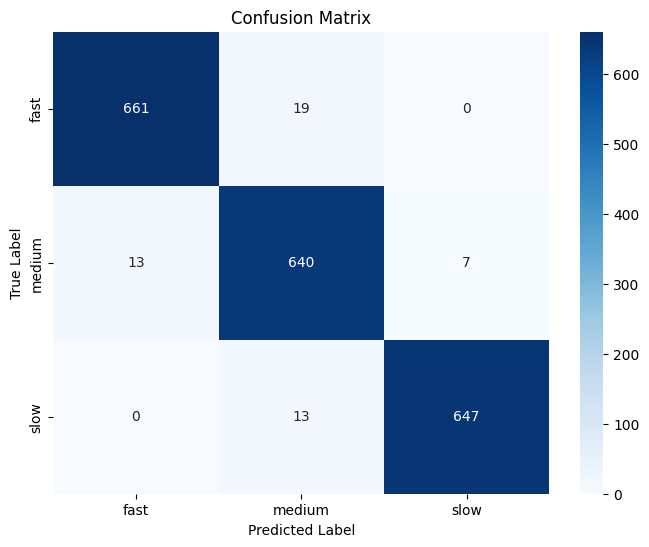

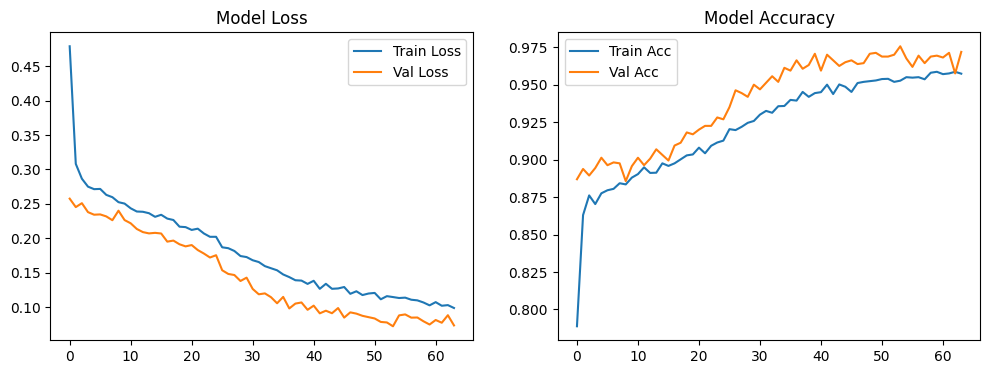

Test Accuracy: 0.9740


In [5]:
# Prediksi pada test set
y_pred_proba = model.predict(X_test)
y_pred = np.argmax(y_pred_proba, axis=1)
y_test_argmax = np.argmax(y_test, axis=1)

# Metrik
print("Classification Report:")
print(classification_report(y_test_argmax, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test_argmax, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.legend()
plt.show()

# Akurasi test
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Accuracy: {test_acc:.4f}")


In [6]:
new_data_slow = pd.DataFrame({
    'age': [50], 'height_cm': [160], 'weight_kg': [80],
    'steps_per_day': [3000], 'BMR': [1300], 'BMI': [31.25],
    'gender_male': [0], 'gender_female': [1]
})
new_data_slow[numerical_features] = scaler.transform(new_data_slow[numerical_features])
pred_proba_slow = model.predict(new_data_slow)
pred_class_slow = label_encoder.inverse_transform(np.argmax(pred_proba_slow, axis=1))
print(f"Test 1: {pred_class_slow[0]} (Prob: {np.max(pred_proba_slow):.4f})")

new_data_medium = pd.DataFrame({
    'age': [21], 'height_cm': [165], 'weight_kg': [65],
    'steps_per_day': [10000], 'BMR': [2200], 'BMI': [23.88],
    'gender_male': [1], 'gender_female': [0]
})
new_data_medium[numerical_features] = scaler.transform(new_data_medium[numerical_features])
pred_proba_medium = model.predict(new_data_medium)
pred_class_medium = label_encoder.inverse_transform(np.argmax(pred_proba_medium, axis=1))
print(f"Test 2: {pred_class_medium[0]} (Prob: {np.max(pred_proba_medium):.4f})")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
Test 1: slow (Prob: 1.0000)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
Test 2: fast (Prob: 1.0000)
